In [63]:
import numpy as np
from scipy.interpolate import BSpline, splrep, UnivariateSpline
import adam
from scipy.signal import bspline
import pandas as pd

from sklearn.preprocessing import StandardScaler
import sparse
import time
from scipy.interpolate._bspl import evaluate_all_bspl
import multiprocessing as mp
import itertools


import sys
import argparse
import os

## IDLFM

In [64]:
def generate_data(n_patients, n_var, T, idx_x, idx_y, rank, k, N):
        D = N-k
        Fx = np.random.randn(n_var,rank)
        Fy = np.random.randn(rank)

        knots = np.array(list(range(1,N-2*k-1)))/(N-2*k-1)*T
        knots = np.insert(knots, 0, (k+1)*[-1])
        knots = np.insert(knots, N-k-1, (k+1)*[T+1])

        weights = np.random.randn(n_patients, rank, D)

        x_data = []
        y_data = []
        for i in range(n_patients):
            # Setting 1.1
            spl = [lambda t: 0.02*i*np.log(t+1), lambda t: 2*np.exp(-(t-60+10*i)/50*(t-60+10*i)+0.0000001) + 4*np.exp(-(t-70+10*i)/20*(t-70+10*i)+0.0000001) , lambda t: np.cos(0.12*np.pi*t) + 1]
           # Setting 1.2
           # spl = [lambda t: 0.02*np.log(t+1), lambda t: 2*np.exp(-(t-60+10*i)/50*(t-60+10*i)+0.0000001) + 4*np.exp(-(t-70+10*i)/20*(t-70+10*i)+0.0000001) , lambda t: np.cos(0.12*np.pi*t) + 1]
            for j in range(n_var):
                tmp = np.matmul(Fx[j,:], [spl[r](idx_x[i,j,:].data) for r in range(rank)])+ 0.5*np.random.randn(len(idx_x[i,j,:].data))
                x_data = np.concatenate((x_data, tmp))
            tmp = np.matmul(Fy, [spl[r](idx_y[i,0,:].data) for r in range(rank)])+ 0.5*np.random.randn(len(idx_y[i,0,:].data))
            y_data = np.concatenate((y_data, tmp))
        print(len(x_data))
        output_x = sparse.COO(idx_x.coords, x_data, shape = (n_patients, n_var, T))
        output_y = sparse.COO(idx_y.coords, y_data, shape = (n_patients, 1, T))


        return [output_x, output_y, knots, weights, Fx, Fy]

In [65]:
def xy_pred(weights, knots, F, n_patients, n_var, idx, rank, k):
        thetas = [[BSpline(knots, weights[i,r,:], k) for r in range(rank)] for i in range(n_patients)]
        data = []
        for i in range(n_patients):
            for j in range(n_var+1):
                tmp = np.matmul(F[j,:],[thetas[i][r](idx[i,j,:].data) for r in range(rank)])
                data = np.concatenate((data, tmp))
        output = sparse.COO(idx.coords, data,shape = (n_patients, n_var+1, idx.shape[2]))
        return output

In [66]:
def dlts(X, Y, n_patients, n_var, T, idx_x, idx_y, rank, k, N, lambda1 = 1, lambda2 = 1, Niter = 100, alpha = 0.001, ebs = 0.0001, l=1):
        beta1 = 0.9
        beta2 = 0.999
        m_w = 0
        m_F = 0
        v_w = 0
        v_F = 0

        D = N-k-1
        F = np.random.randn(n_var+1,rank)


        coords = np.copy(Y.coords)
        coords[1,:] = n_var
        coords = np.concatenate((X.coords,coords), axis = 1)
        data = np.concatenate((X.data,Y.data))
        xy = sparse.COO(coords, data, shape = (n_patients, n_var+1, T))


        knots = np.array(list(range(1,N-2*k-1)))/(N-2*k-1)*T
        knots = np.insert(knots, 0, (k+1)*[-1])
        knots = np.insert(knots, N-k-1, (k+1)*[T+1])

        coords = np.copy(idx_y.coords)
        coords[1,:] = n_var
        coords = np.concatenate((idx_x.coords,coords), axis = 1)
        data = np.concatenate((idx_x.data,idx_y.data))
        idx = sparse.COO(coords, data, shape = (n_patients, n_var+1, T))

        weights = np.random.randn(n_patients, rank, D)
        xy_hat = xy_pred(weights, knots, F, n_patients, n_var, idx, rank, k)


        nobs = len(data)
        S = np.sum((xy - xy_hat)**2)/nobs
        S_record = [S]
        print(S)

        K = np.zeros((D, T), dtype=np.float_)
        for t in range(T):
            xval = t
            if xval <= knots[k]:
                left = k
            else:
                left = np.searchsorted(knots, xval) - 1

            # fill a row
            bb = evaluate_all_bspl(knots*1.0, k, xval, left)
            K[left-k:left+1, t] = bb

        for itr in range(Niter):
            unique_t = np.sort(list(set(idx.data)))
            theta = np.tensordot(weights, K, axes = (2,0))
            grad_weights = np.tensordot(2*(xy_hat - xy), F, axes = (1, 0))
            grad_weights = np.tensordot(grad_weights, K, axes = (1, 1))
            ## Fused lasso for theta_i
            grad_pen = np.empty(weights.shape)
            trans_m = -np.eye(n_patients- 1)
            for i in range(n_patients):
                tmp = np.tensordot(np.insert(trans_m, i, np.ones(n_patients-1), axis=1), weights, axes = (1,0))
                tmp = np.sign(tmp)
                grad_pen[i] = np.sum(tmp, axis = 0)
            ##total variation for bspline
            jump = np.insert(-np.eye(D-1), 0, np.zeros(D-1), axis = 1)
            jump = np.insert(jump, D-1, np.zeros(D), axis = 0)
            jump = jump + np.eye(D)
            jump_m = jump
            if k > 1:
                for i in range(k):
                    jump_m = np.matmul(jump_m, jump)
            grad_pen1 = np.tensordot(weights, jump_m.T, axes = (2, 0))
            grad_pen1 = np.sign(grad_pen1)
            grad_pen1 = np.tensordot(grad_pen1[:,:,0:(D-k)], jump_m[0:(D-k)], axes = (2, 0))
            grad_weights = grad_weights + l*weights + lambda1 * grad_pen + lambda2 * grad_pen1
            grad_F = np.tensordot(2*(xy_hat - xy),theta, axes = ([0,2],[0,2]))
            grad_F += l*F

            m_w = beta1*m_w + (1-beta1) * grad_weights
            m_F = beta1*m_F + (1-beta1) * grad_F
            v_w = beta2 * v_w + (1-beta2) * grad_weights**2
            v_F = beta2 * v_F + (1-beta2) * grad_F**2
            mhat_w = m_w / (1-beta1)
            mhat_F = m_F / (1 - beta1)
            vhat_w = v_w / (1 - beta2)
            vhat_F = v_F / (1 - beta2)
            beta1 = beta1**(i+1)
            beta2 = beta2**(i+1)

            weights = weights - alpha * mhat_w /(np.sqrt(vhat_w) + 1e-8)
            F = F - alpha * mhat_F /(np.sqrt(vhat_F) + 1e-8)

            xy_hat = xy_pred(weights, knots, F, n_patients, n_var, idx, rank, k)
            S = np.sum((xy -xy_hat)**2)/nobs
            t = np.abs((S_record[-1] - S)/S_record[-1])
            if i > 10 and S >= np.max(S_record):
                print('Diverge')
                break
            if t < ebs:
                print(itr)
                print('Converge')
                S_record.append(S)
                break
            if itr%100 == 0:
                print(itr, S)

        print('Max iteration')
        X_hat = xy_hat[:, 0:n_var, :]
        Y_hat = xy_hat[:, n_var, :]
        Y_hat = Y_hat.reshape((n_patients, 1, T))

        return [weights, F, X_hat, Y_hat]

In [67]:
I = 33 # # of patients
J = 5 # # of variables for X
#T = 96 # max time
T = 1000
R = 3 # Rank
k = 3 # smooth degree for spline function
N = 300 # number of knots in spline function
D = N-k-1 # # of base spline function, determined by # of knots and smooth degree

In [68]:
#    ############# Multiresolution
idx_x = sparse.random((I, J, T), density = 0.8)
idx_y_train = sparse.random((I, 1, T), density = 0.2)
idx_y_test = sparse.random((I, 1, T), density = 0.2)

In [69]:
data = generate_data(I, J, T, idx_x, idx_y_train, R, k, N)
print(data)

132000
[<COO: shape=(33, 5, 1000), dtype=float64, nnz=132000, fill_value=0.0>, <COO: shape=(33, 1, 1000), dtype=float64, nnz=6600, fill_value=0.0>, array([-1.00000000e+00, -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        3.41296928e+00,  6.82593857e+00,  1.02389078e+01,  1.36518771e+01,
        1.70648464e+01,  2.04778157e+01,  2.38907850e+01,  2.73037543e+01,
        3.07167235e+01,  3.41296928e+01,  3.75426621e+01,  4.09556314e+01,
        4.43686007e+01,  4.77815700e+01,  5.11945392e+01,  5.46075085e+01,
        5.80204778e+01,  6.14334471e+01,  6.48464164e+01,  6.82593857e+01,
        7.16723549e+01,  7.50853242e+01,  7.84982935e+01,  8.19112628e+01,
        8.53242321e+01,  8.87372014e+01,  9.21501706e+01,  9.55631399e+01,
        9.89761092e+01,  1.02389078e+02,  1.05802048e+02,  1.09215017e+02,
        1.12627986e+02,  1.16040956e+02,  1.19453925e+02,  1.22866894e+02,
        1.26279863e+02,  1.29692833e+02,  1.33105802e+02,  1.36518771e+02,
        1.39931741e+02,  1.

In [70]:
output_x = data[0]
output_y = data[1]
knots = data[2]
weights = data[3]
Fx = data[4]
Fy = data[5]

In [71]:
result = dlts(X = output_x, Y = output_y, n_patients = I, n_var = J, T = T, idx_x = idx_x, idx_y = idx_y_train, rank = R, k = k, N = N)
print(result)

7.7275882661244735
0 7.721288726984253
Max iteration
[array([[[-1.20986775, -0.82281005,  1.1508544 , ...,  0.5767581 ,
          1.12554871, -0.56130181],
        [ 0.00305677,  2.05745716,  0.01731997, ...,  1.22761329,
         -1.36968583,  1.05242245],
        [ 0.08972995,  2.14278425, -0.06225397, ..., -0.36624146,
         -0.23533962, -0.76504597]],

       [[ 1.14607956,  0.21473549,  0.34846591, ..., -0.92079823,
          0.20745268,  0.13132283],
        [ 0.92533909, -0.32526013,  0.07989919, ...,  0.00328087,
         -1.24806147,  1.39091877],
        [ 0.04813489,  1.17866822,  0.56434569, ..., -0.34500858,
         -0.45672873, -0.84966783]],

       [[-0.52868505,  0.17689771, -0.89692175, ..., -1.11461705,
         -0.49495082,  0.13090636],
        [-0.61734352,  0.11531338, -0.98977391, ...,  0.06596245,
         -0.90271423,  0.75498735],
        [-1.71571746,  0.01300314,  0.00697935, ..., -0.41904116,
         -1.35181609,  2.16563376]],

       ...,

       [[

## CP
## 1. Setting
I = 33 # # of patients

J = 5 # # of variables for X

T = 1000

R = 3 # Rank

k = 3 # smooth degree for spline function

N = 300 # number of knots in spline function

D = N-k-1 # # of base spline function, determined by # of knots and smooth degree

$\mathcal{D}_{train}=\left\{\left(i, j, t, Y_{i j}(t)\right) \in \mathcal{D}: j=1, \ldots, J\right\}$ with resolution=0.8 when $j=1, \dots, J-1$, and resolution=0.2 when $j=J$, $N_{train}=132000$

$\mathcal{D}_{cal}=\left\{\left(i, j, t, Y_{i j}(t)\right) \in \mathcal{D}: j=J\right\}$ with resolution=0.2, $N_{cal}=6600$

In [ ]:
weights = result[0]
F = result[1]
X = data[0]
Fy = data[5]

### Y_cal

In [73]:
y_cal_data = []
for i in range(I):
    spl = [lambda t: 0.02*i*np.log(t+1), lambda t: 2*np.exp(-(t-60+10*i)/50*(t-60+10*i)+0.0000001) + 4*np.exp(-(t-70+10*i)/20*(t-70+10*i)+0.0000001) , lambda t: np.cos(0.12*np.pi*t) + 1]
    tmp = np.matmul(Fy, [spl[r](idx_y_test[i,0,:].data) for r in range(R)])+ 0.5*np.random.randn(len(idx_y_test[i,0,:].data))
    y_cal_data = np.concatenate((y_cal_data, tmp))
Y_cal = sparse.COO(idx_y_test.coords, y_cal_data, shape = (I, 1, T))
print(Y_cal)


<COO: shape=(33, 1, 1000), dtype=float64, nnz=6600, fill_value=0.0>


### Y_cal_hat

In [74]:
def y_pred(weights, knots, F, n_patients, idx_y, rank, k):
        thetas = [[BSpline(knots, weights[i,r,:], k) for r in range(rank)] for i in range(n_patients)]
        data = []
        for i in range(n_patients):
            #for j in range(n_var+1):
                tmp = np.matmul(F[0,:],[thetas[i][r](idx_y[i,0,:].data) for r in range(rank)])
                data = np.concatenate((data, tmp))
        output = sparse.COO(idx_y.coords, data,shape = (I, 1, idx_y.shape[2]))
        return output

In [75]:
Y_cal_hat = y_pred(weights, knots, F, I, idx_y_test, R, k)
print(Y_cal_hat)

<COO: shape=(33, 1, 1000), dtype=float64, nnz=6600, fill_value=0.0>


## 2. nonconformity scores

In [76]:
def calculate_nonconformity_score(Y_cal, Y_cal_hat):
    assert Y_cal.shape == Y_cal_hat.shape, "Shapes of Y_cal and Y_cal_hat do not match."
    nonconformity_scores = np.abs(Y_cal.data - Y_cal_hat.data)
    
    return nonconformity_scores

nonconformity_scores = calculate_nonconformity_score(Y_cal, Y_cal_hat)
print("Nonconformity Scores:", nonconformity_scores)

Nonconformity Scores: [2.1816985  2.84020204 3.82487505 ... 2.33136937 2.14203433 3.42924262]


## 3. Standard ACI

In [ ]:
def calculate_alpha_tilde(Y_cal, Y_cal_hat, nonconformity_scores, alpha, eta=0.005):
 
    Y_cal_values = Y_cal.data  
    Y_cal_hat_values = Y_cal_hat.data  
    
    alpha_tilde = alpha
    alpha_tilde_history = []
    for k, (Y_k, Y_hat_k) in enumerate(zip(Y_cal_values, Y_cal_hat_values)):
        if k == 0:
            continue  
        
        threshold = np.quantile(nonconformity_scores, 1 - alpha_tilde)
        
        interval_lower = Y_hat_k - threshold
        interval_upper = Y_hat_k + threshold
        in_interval = interval_lower <= Y_k <= interval_upper
        
        alpha_tilde = alpha_tilde - eta * (1 if not in_interval else 0 - alpha)
        alpha_tilde_history.append(alpha_tilde)
      
        print(f"Iteration {k}:")
        print(f"  alpha_tilde = {alpha_tilde}")
        print(f"  Prediction interval for Y_hat_k = [{interval_lower}, {interval_upper}]")
        print(f"  Y_k = {Y_k} {'within' if in_interval else 'outside'} the interval\n")
        
        if alpha_tilde <= 0 or alpha_tilde >= 1:
            print("Convergence reached. Exiting.")
            break
    
    return alpha_tilde, alpha_tilde_history

alpha = 0.1  
eta = 0.005   
nonconformity_scores = calculate_nonconformity_score(Y_cal, Y_cal_hat)
alpha_tilde, alpha_tilde_history = calculate_alpha_tilde(Y_cal, Y_cal_hat, nonconformity_scores, alpha, eta)
print("Final adjusted significance level (alpha_tilde):", alpha_tilde)

Iteration 1:
  alpha_tilde = 0.1005
  Prediction interval for Y_hat_k = [-5.140399906576194, 0.7066664946948444]
  Y_k = 0.6233353330038698 within the interval

Iteration 2:
  alpha_tilde = 0.0955
  Prediction interval for Y_hat_k = [-5.291858999064425, 0.5381880870398645]
  Y_k = 1.4480395903346834 outside the interval

Iteration 3:
  alpha_tilde = 0.0905
  Prediction interval for Y_hat_k = [-4.880383415509697, 1.0888494182313153]
  Y_k = 1.1598644133026483 outside the interval

Iteration 4:
  alpha_tilde = 0.08549999999999999
  Prediction interval for Y_hat_k = [-5.13575564281784, 0.95582346494158]
  Y_k = 1.2072833009383264 outside the interval

Iteration 5:
  alpha_tilde = 0.08049999999999999
  Prediction interval for Y_hat_k = [-5.589058281691244, 0.6392086894589926]
  Y_k = 1.0809823398705423 outside the interval

Iteration 6:
  alpha_tilde = 0.08099999999999999
  Prediction interval for Y_hat_k = [-5.0866901441794585, 1.3065083913046687]
  Y_k = -0.05493202770952521 within the i

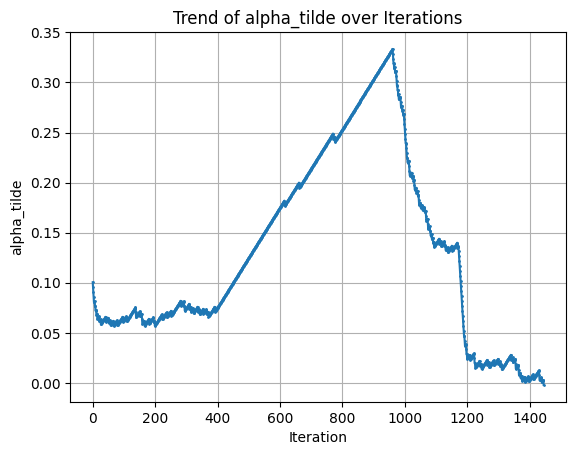

In [78]:
import matplotlib.pyplot as plt
# Plot the trend of alpha_tilde over iterations
plt.plot(alpha_tilde_history, marker='o', markersize=1)
plt.xlabel('Iteration')
plt.ylabel('alpha_tilde')
plt.title('Trend of alpha_tilde over Iterations')
plt.grid(True)
plt.show()

## 4. Simplified ACI

In [87]:
def calculate_alpha_tilde_sACI(Y_cal, Y_cal_hat, nonconformity_scores, alpha, delta=0.01, max_iter=100):
   
    Y_cal_values = Y_cal.data  
    Y_cal_hat_values = Y_cal_hat.data  
    alpha_tilde = alpha
    N_cal = len(Y_cal_values)
    
    for iteration in range(max_iter):
        threshold = np.quantile(nonconformity_scores, 1 - alpha_tilde)
        outside_count = 0
        print(f"\nIteration {iteration}: alpha_tilde = {alpha_tilde}")
        
        for k, (Y_k, Y_hat_k) in enumerate(zip(Y_cal_values, Y_cal_hat_values)):
            interval_lower = Y_hat_k - threshold
            interval_upper = Y_hat_k + threshold
            in_interval = interval_lower <= Y_k <= interval_upper
            if not in_interval:
                outside_count += 1
            
            # Print the details for the current calibration point
            print(f"  Point {k}:")
            print(f"    Y_k = {Y_k}")
            print(f"    Interval = [{interval_lower}, {interval_upper}]")
            print(f"    Y_k is {'within' if in_interval else 'outside'} the interval")
        # Print the outside count for this iteration
        print(f"  Outside count = {outside_count}")
       
        empirical_coverage_error = outside_count / N_cal - alpha
        print(f"  Empirical coverage error = {empirical_coverage_error}")
        if abs(empirical_coverage_error) <= delta:
            print("Convergence reached within tolerance.")
            break

        alpha_tilde += delta * np.sign(empirical_coverage_error)
        alpha_tilde = max(0, min(1, alpha_tilde))
    
    return alpha_tilde

alpha = 0.1  
delta = 0.005  
alpha_tilde = calculate_alpha_tilde_sACI(Y_cal, Y_cal_hat, nonconformity_scores, alpha, delta)
print("\nFinal adjusted significance level (alpha_tilde):", alpha_tilde)


Iteration 0: alpha_tilde = 0.1
  Point 0:
    Y_k = 0.4180604367449959
    Interval = [-4.687171265575328, 1.1598951356957106]
    Y_k is within the interval
  Point 1:
    Y_k = 0.6233353330038698
    Interval = [-5.140399906576194, 0.7066664946948444]
    Y_k is within the interval
  Point 2:
    Y_k = 1.4480395903346834
    Interval = [-5.3003686566478, 0.5466977446232391]
    Y_k is outside the interval
  Point 3:
    Y_k = 1.1598644133026483
    Interval = [-4.81930019927471, 1.0277662019963285]
    Y_k is outside the interval
  Point 4:
    Y_k = 1.2072833009383264
    Interval = [-5.01349928957365, 0.8335671116973891]
    Y_k is outside the interval
  Point 5:
    Y_k = 1.0809823398705423
    Interval = [-5.398457996751645, 0.4486084045193932]
    Y_k is outside the interval
  Point 6:
    Y_k = -0.05493202770952521
    Interval = [-4.813624077072914, 1.0334423241981243]
    Y_k is within the interval
  Point 7:
    Y_k = 0.2391037521093905
    Interval = [-4.9526886023981955, 

## 5. Prediction Interval Function

In [88]:
def calculate_prediction_interval(Y_test_pred, nonconformity_scores, alpha_tilde):
    threshold = np.quantile(nonconformity_scores, 1 - alpha_tilde)
    lower_bound = Y_cal_hat - threshold
    upper_bound = Y_cal_hat + threshold
    
    return (lower_bound, upper_bound)

prediction_intervals = calculate_prediction_interval(Y_cal_hat, nonconformity_scores, alpha_tilde)
print("Prediction Interval:", prediction_intervals)


Prediction Interval: (<COO: shape=(33, 1, 1000), dtype=float64, nnz=6600, fill_value=-2.9235332006355192>, <COO: shape=(33, 1, 1000), dtype=float64, nnz=6600, fill_value=2.9235332006355192>)


In [89]:
prediction_intervals_dict = {}

for idx, value in enumerate(Y_cal_hat.data):
    # Get the coordinates (I, J, T) for the current non-zero entry
    I, J, T = Y_cal_hat.coords[:, idx]
    # Calculate the prediction interval for this entry
    lower_bound, upper_bound = calculate_prediction_interval(value, nonconformity_scores, alpha_tilde)
    prediction_intervals_dict[(I, J, T)] = (lower_bound, upper_bound)

for (I, J, T), interval in prediction_intervals_dict.items():
    print(f"Prediction Interval for (I={I+1}, J={J+1}, T={T+1}): {interval}")


Prediction Interval for (I=1, J=1, T=3): (<COO: shape=(33, 1, 1000), dtype=float64, nnz=6600, fill_value=-2.9235332006355192>, <COO: shape=(33, 1, 1000), dtype=float64, nnz=6600, fill_value=2.9235332006355192>)
Prediction Interval for (I=1, J=1, T=7): (<COO: shape=(33, 1, 1000), dtype=float64, nnz=6600, fill_value=-2.9235332006355192>, <COO: shape=(33, 1, 1000), dtype=float64, nnz=6600, fill_value=2.9235332006355192>)
Prediction Interval for (I=1, J=1, T=9): (<COO: shape=(33, 1, 1000), dtype=float64, nnz=6600, fill_value=-2.9235332006355192>, <COO: shape=(33, 1, 1000), dtype=float64, nnz=6600, fill_value=2.9235332006355192>)
Prediction Interval for (I=1, J=1, T=12): (<COO: shape=(33, 1, 1000), dtype=float64, nnz=6600, fill_value=-2.9235332006355192>, <COO: shape=(33, 1, 1000), dtype=float64, nnz=6600, fill_value=2.9235332006355192>)
Prediction Interval for (I=1, J=1, T=30): (<COO: shape=(33, 1, 1000), dtype=float64, nnz=6600, fill_value=-2.9235332006355192>, <COO: shape=(33, 1, 1000), 